# Семантическая сегментация изображений

В этом ipython notebook будет рассмотрен алгоритм решения задачи семантической сегментации изображения с помощью полносверточной нейронной сети и Марковского Случайного Поля. 

Для корректной работы требуются следующие библиотеки:
* Python (>=3.5)
* cython (>=0.22), numpy, scikit-image, tensorflow (>=1.8.0), tqdm, matplotlib, pandas
* PyDenseCRF (установка последней версии: ```pip install git+https://github.com/lucasb-eyer/pydensecrf.git```)

In [1]:
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io
import tensorflow as tf

from tqdm import tqdm

from model_fcn8s import FCN8s
from utils import construct_dataset, reshape_and_filter_batch

%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# network params
TEST_BATCH = 2

# pre-defined values for PASCALVOC
N_CLASSES = 21
IGN_LABEL = 255  # IGN_LABEL defines ambigious regions on images, all these regions are not considered during training / evaluation
TST_SIZE = 1449

# inference options
# Requires large amount of RAM (~20GB in total), if turned off - dumps everything on disk
RESULTS_BUFFER = False 
# If you have GPU, FCN8-s model is used instead of FCN32-s
WITH_GPU = False

## Датасет и модель

В качестве модели будет использовать полносверточная сеть FCN-8s (или FCN-32s в случае запуска на CPU), предложенная в статье [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1605.06211.pdf). Авторы предлагают способ преобразования архитектуры VGG-16 в полносверточную нейронную сеть путем замены последних полносвязных слоев на сверточные, соответствующего размера. Еще одно новшество данной архитектуры - комбинирование предсказаний по выходам различных по глубине слоев сети для повышения качества сегментации. Например, для архитектуры FCN-32s в конце работы происходит upsampling результирующей семантической карты в 32 раза, что в итоге дает достаточно грубые предсказания границ. Для архитектуры FCN-8s повышение разрешения происходит поэтапно (2x->2x->8x), при этом после первых двух увеличений размерности к результату прибавляются предсказания на основе выходов других слоев (pool4 и pool3 соответственно), что позволяет значительно повысить точность результирующей семантической карты. Архитектура FCN-8s: <img src="ipynb_pictures/fcn.png">

Для экспериментов будет использоваться датасет [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), изображения в котором содержат объекты 21 класса (включая фон).

Ниже представлен код для загрузки изображений с помощью предварительно полученных [tfrecord](https://www.tensorflow.org/guide/datasets), а так же весов предобученной модели. Для передачи изображений в модель будет использоваться TFRecordDataset с one_shot_iterator, подробнее почитать о датасетах и итераторах в TF можно, например, [здесь](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428).

Перед запуском следующей клетки обратите внимание на флаги в предыдущей - RESULTS_BUFFER и WITH_GPU, выставьте их в зависимости от имеющихся в вашем распоряжении ресурсов.

In [3]:
# load tfrecords to dataset object
test_dataset = construct_dataset('./tfrecord/', 'val')
# enable batching
test_dataset = test_dataset.batch(TEST_BATCH)
# create one-shot iterator
iterator = test_dataset.make_one_shot_iterator()
next_batch_op = iterator.get_next()
# load pretrained weights (if you have GPU consider using 'reduced=False')
model_eval = FCN8s("./weights/fcn{}s.npy".format(8 if WITH_GPU else 32), reduced=not(WITH_GPU))
# placeholder to turn dropout off at test time
dropout_prob = tf.placeholder_with_default(1.0, shape=())
# forward pass of the model (logits for loss, soft_logits for dense-CRF)
logits, soft_logits = model_eval.build(next_batch_op['img'], dropout_prob)
# filtering the IGN_LABEL from masks and logits for correct loss computation
filter_logits, filter_labels = reshape_and_filter_batch(logits, next_batch_op['mask'])
# applying loss
loss = tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=filter_logits, labels=filter_labels)
mean_loss = tf.reduce_mean(loss)
# global initialization
init = tf.global_variables_initializer()

## Предсказание семантической карты с помощью предобученной модели

Код в клетке ниже получает предсказания для всех 1449 изображений из validation части PASCAL VOC. Изображения и эталонные маски так же сохраняются для того, чтобы в конце можно было наглядно оценить результаты.

In [4]:
if RESULTS_BUFFER:
    predictions = []
    groundtruth = []
    images = []
else:
    os.makedirs('./data/images', exist_ok=True)
    os.makedirs('./data/masks', exist_ok=True)
    os.makedirs('./data/predictions', exist_ok=True)
    
filenames = []
evaluation_loss = 0
with tf.Session() as sess:
    sess.run(init)

    for batch_i in tqdm(range(0, math.ceil(TST_SIZE / TEST_BATCH))):
        preds, gts, imgs, fnames, m_loss = sess.run(
            [
                soft_logits, next_batch_op['mask'], next_batch_op['img'], 
                next_batch_op['filename'], mean_loss
            ],
            feed_dict={dropout_prob: 1.0})
        
        fnames = [fname.decode() for fname in fnames]
        filenames.extend(fnames)
        if RESULTS_BUFFER:
            predictions.extend(preds)
            groundtruth.extend(gts)
            images.extend(imgs)
        else:
            for i in range(0, len(preds)):
                io.imsave('./data/images/{}.jpg'.format(fnames[i]), imgs[i])
                io.imsave('./data/masks/{}.png'.format(fnames[i]), gts[i])
                np.save('./data/predictions/{}.npy'.format(fnames[i]), preds[i])
        evaluation_loss += m_loss
print('Evaluation loss is: {:.6f}'.format( evaluation_loss / TST_SIZE))

100%|██████████| 725/725 [16:33<00:00,  1.20s/it]

Evaluation loss is: 0.273789


## Оценка точности предсказаний
Используемые метрики:
1. пиксельная точность (pixel accuracy): $\sum_{c=1}^{N_c}{n_{cc}}~/~\sum_{c=1}^{N_c}{n_c}$;
2. средняя точность (mean accuracy): $\frac{1}{N_c}\sum_{c=1}^{N_c}{(n_{cc}~/~n_c)}$;
3. средний коэффициент Жаккара (mean intersection over union): 
$\frac{1}{N_c}\sum_{c=1}^{N_c}{[n_{cc}~/~(n_c+\sum_{c'}^{N_c}{n_{c'c}}-n_{cc})]}$;

где: 
* $N_c$ - число классов в эталонной разметке для рассматриваемого изображения;
* $n_{ij}$ - число пикселей класса $i$, с предсказанным классом $j$ на рассматриваемом изображении;
* $n_c=\sum_{j}^{N_c}{n_{cj}}$ - общее число пикселей с эталонным классом $c$ на рассматриваемом изображении.

Реализуйте три метрики по описанным выше формулам.

In [5]:
EPS = 1e-5

def pixel_accuracy(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    return np.sum(pred == mask) / np.sum(mask != 255)

def mean_accuracy(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    result = 0
    for class_index in range(N_CLASSES):
        n_c = (mask == class_index)
        if n_c.any():
            result += np.sum((pred == mask) & n_c) / n_c.sum()
    return result / (np.unique(mask).size - 1)

def mean_iu(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    result = 0
    for class_index in range(N_CLASSES):
        n_c = (mask == class_index)
        n_cc = np.sum((pred == mask) & n_c)
        if n_c.any():
            result += n_cc / (n_c.sum() + np.sum(pred == class_index) - n_cc)
    return result / (np.unique(mask).size - 1)

## Пост обработка предсказаний с помощью Dense-CRF

Для улучшения качества предсказаний модели будем изпользовать Полносвязное Марковское Случайное Поле ([оригинальная статья](http://www.philkr.net/papers/2011-12-01-nips/2011-12-01-nips.pdf) и [python интерфейс](https://github.com/lucasb-eyer/pydensecrf)).

В процессе работы Dense-CRF минимизирует функцию энергии, заданную пользователем. Функционирование Dense-CRF для нашей задачи можно интерпретировать следующим образом: исходное RGB изображение используется для того чтобы точнее локализовать предсказания (например, цвет на границах объекта обычно сильно изменяется, поэтому делается предположение, что по разную сторону от таких границ лежат объекты разных классов), а на основе карты сегментации полученной из нейронной сети можно отбирать только наиболее правдоподобные предсказания (например, делается предположение, что все отсегментированные объекты имеют достаточно большой размер на изображении).

Разберитесь с python интерфейсом и используйте его для того, чтобы задать корректные унарные и парные потенциалы для нашей задачи.

In [6]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

# placeholders for metrics' values before and after post-processing
metrics_before = np.zeros(3, dtype=np.float32)
metrics_after = np.zeros(3, dtype=np.float32)
if RESULTS_BUFFER:
    predictions_pp = []
else:
    os.makedirs('./data/predictions_pp', exist_ok=True)

for index, fname in tqdm(enumerate(filenames), total=len(filenames)):
    # selecting the next image to process
    if RESULTS_BUFFER:
        img, y_pred, y_true = images[index], predictions[index], groundtruth[index]
    else:
        img = io.imread('./data/images/{}.jpg'.format(fname))
        y_true = io.imread('./data/masks/{}.png'.format(fname))
        y_pred = np.load('./data/predictions/{}.npy'.format(fname))
    # creating a DenseCRF object
    d = dcrf.DenseCRF2D(img.shape[0], img.shape[1], N_CLASSES)
    # Unary potential from softmax
    softmax = y_pred.transpose((2, 0, 1)).reshape((N_CLASSES, -1))
    
    unary_potential = unary_from_softmax(softmax)
    d.setUnaryEnergy(unary_potential.copy(order='C'))
    
    d.addPairwiseGaussian(
        sxy=(3,3), 
        compat=3, 
        kernel=dcrf.DIAG_KERNEL, 
        normalization=dcrf.NORMALIZE_SYMMETRIC
    )

    d.addPairwiseBilateral(
        sxy=(80,80), 
        srgb=(13,13,13), 
        rgbim=img, 
        compat=10, 
        kernel=dcrf.DIAG_KERNEL, 
        normalization=dcrf.NORMALIZE_SYMMETRIC
    )
    
    # inference
    Q = d.inference(5)
    # results
    y_pred_pp = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    # save results
    if RESULTS_BUFFER:
        predictions_pp.append(y_pred_pp)
    else:
        io.imsave('./data/predictions_pp/{}.png'.format(fname), y_pred_pp)
    # calculation of metrics
    metrics_before += [pixel_accuracy(y_pred, y_true), mean_accuracy(y_pred, y_true), mean_iu(y_pred, y_true)]
    metrics_after += [pixel_accuracy(y_pred_pp, y_true), mean_accuracy(y_pred_pp, y_true), mean_iu(y_pred_pp, y_true)]
# getting mean value of metrics    
metrics_before /= TST_SIZE
metrics_after /= TST_SIZE
# print metrics in table
metrics_df = pd.DataFrame([metrics_before, metrics_after],
                          index=['NN', 'NN and dense-CRF'],
                          columns=['pixel_accuracy', 'mean_accuracy', 'mean_iu'])
metrics_df.head()

100%|██████████| 1449/1449 [03:57<00:00,  6.21it/s]


,pixel_accuracy,mean_accuracy,mean_iu
NN,0.834392,0.658655,0.528613
NN and dense-CRF,0.833344,0.603847,0.499358


## Визуализация результатов

Визуализируйте полученные результаты - до и после пост обработки, чтобы оценить качество. Пример визуализации:
<img src="ipynb_pictures/vis_example.png">

							 205


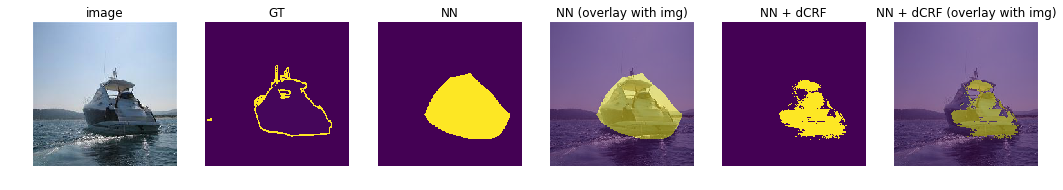

							 590


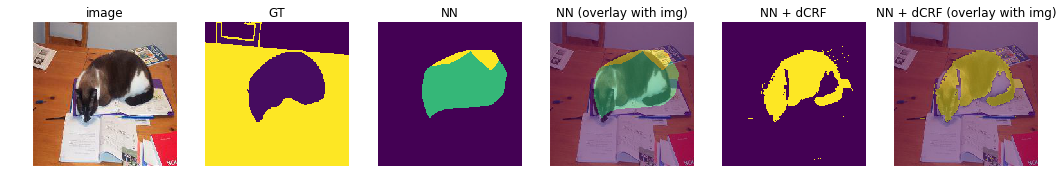

							 401


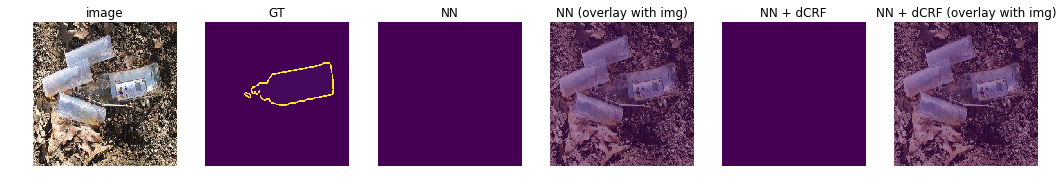

							 346


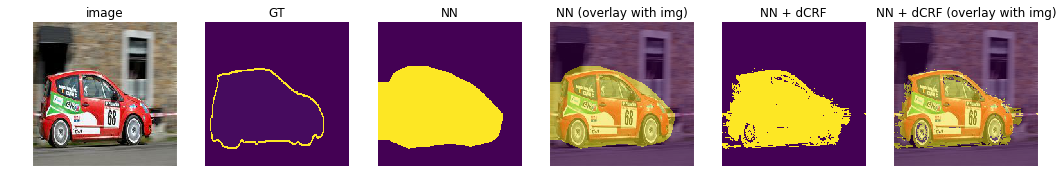

							 997


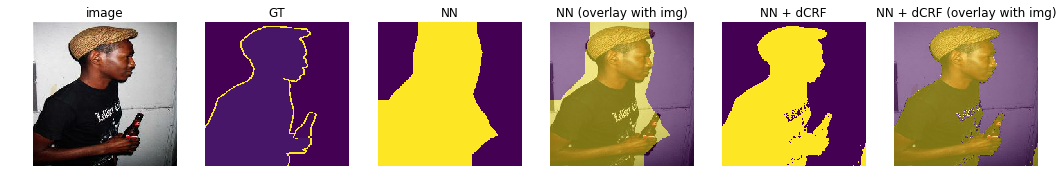

							 516


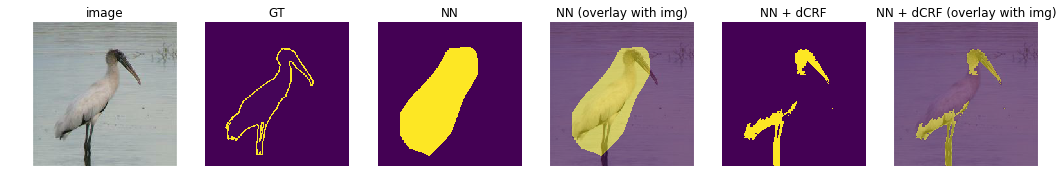

							 1272


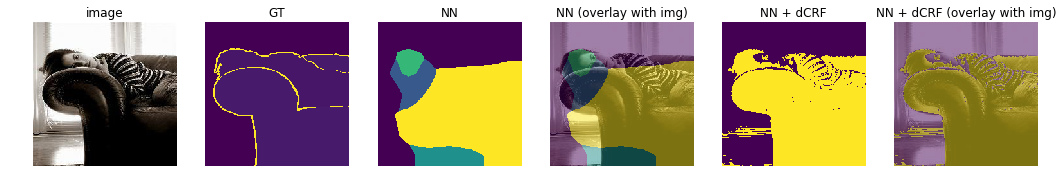

							 300


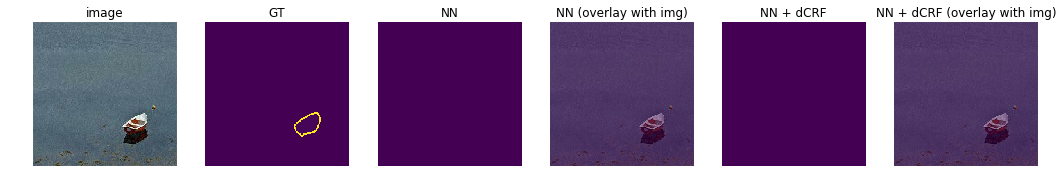

							 1178


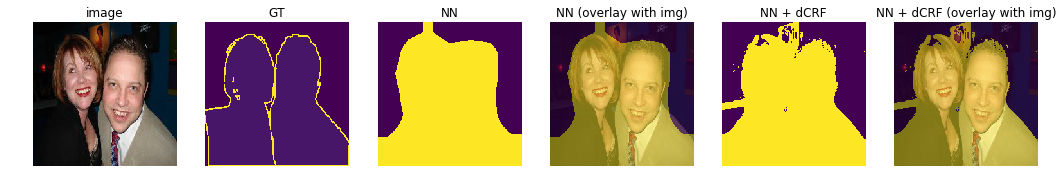

							 223


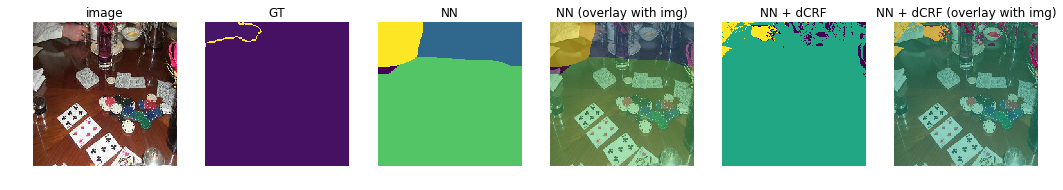

							 684


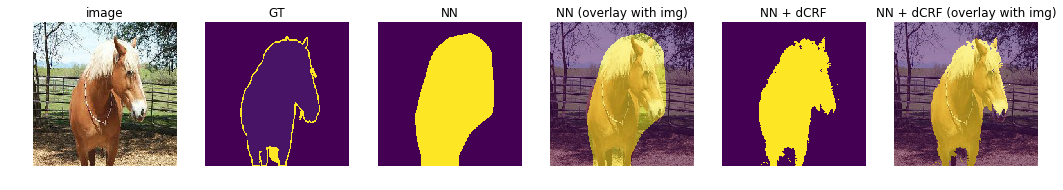

							 90


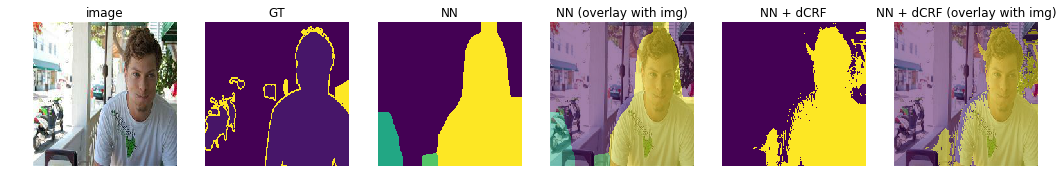

							 1287


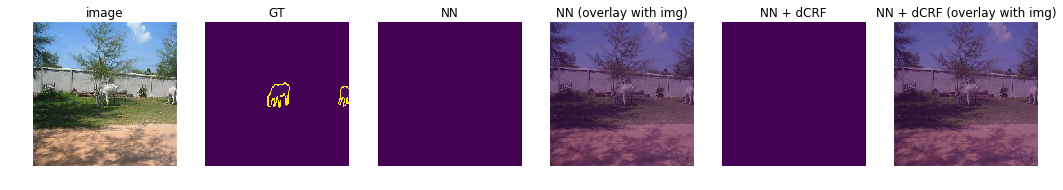

							 1250


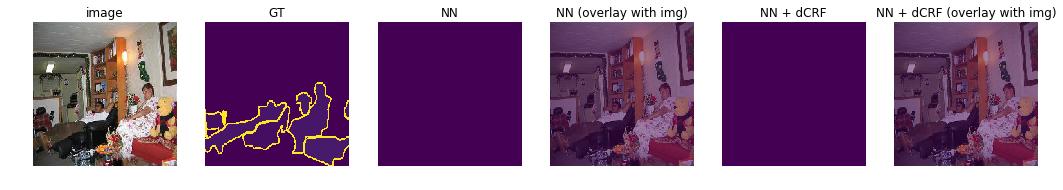

							 392


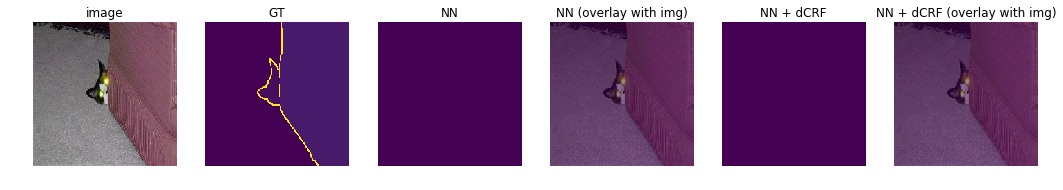

							 321


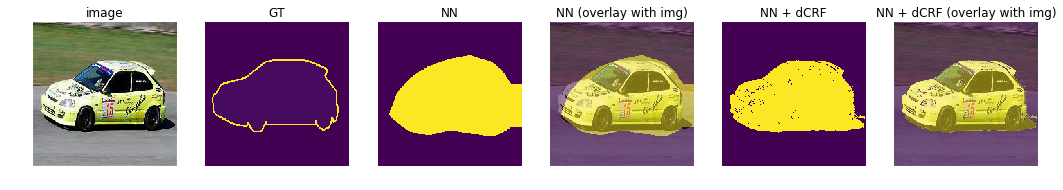

							 202


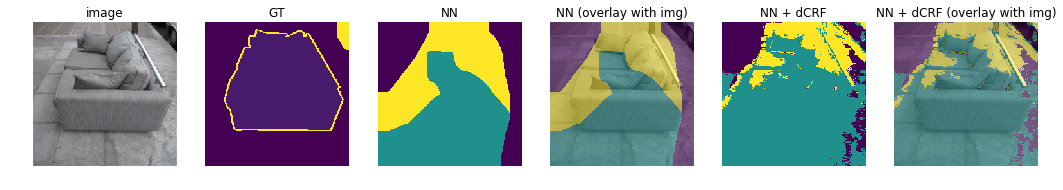

							 158


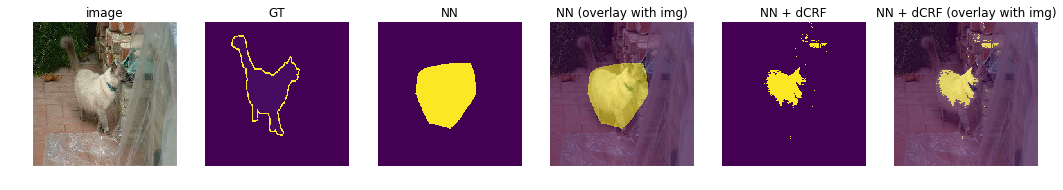

							 101


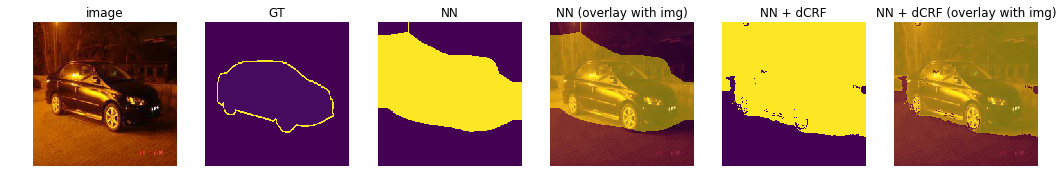

							 513


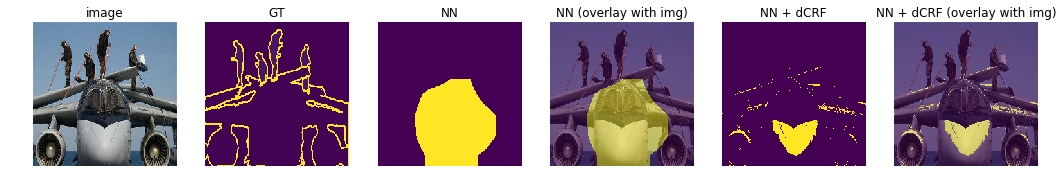

							 473


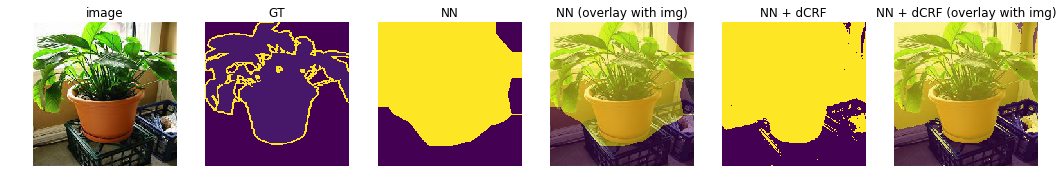

							 405


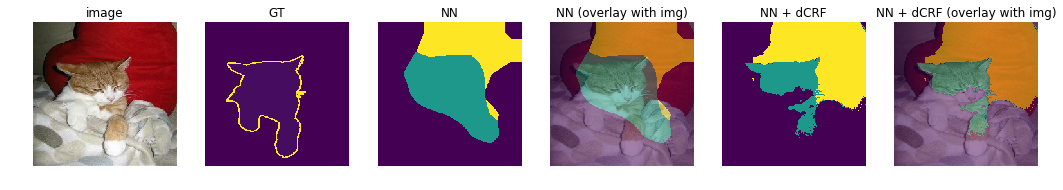

							 80


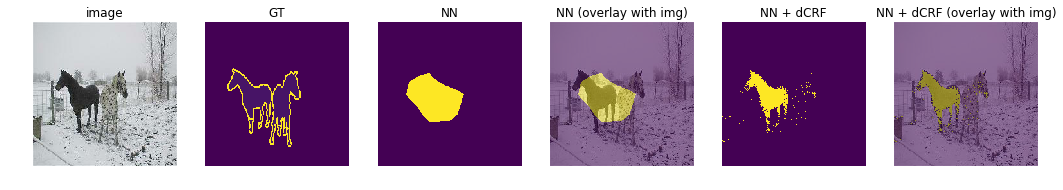

							 220


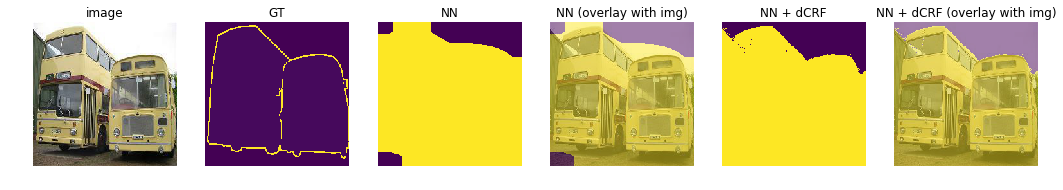

							 1171


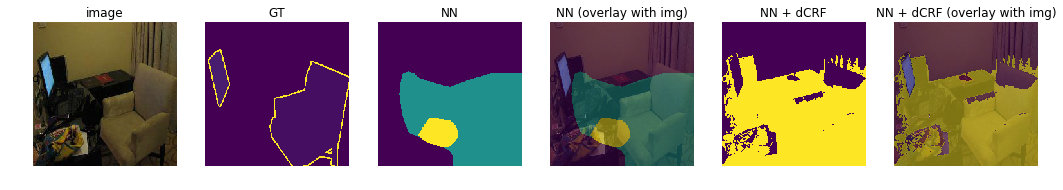

							 891


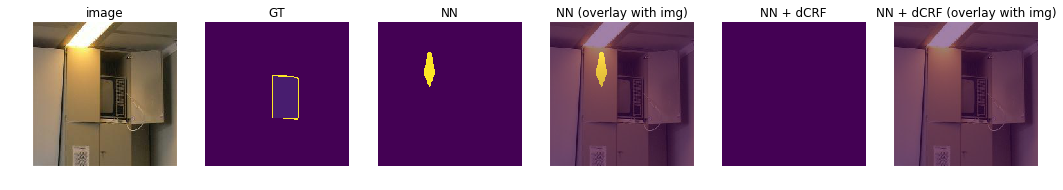

							 1072


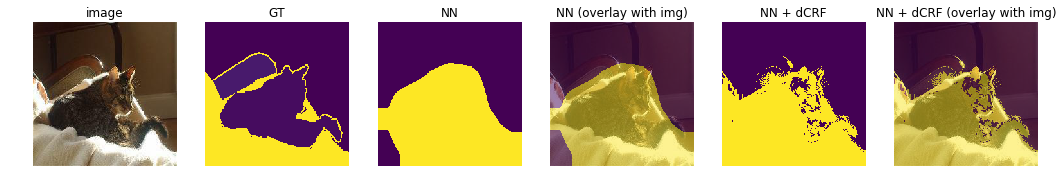

							 533


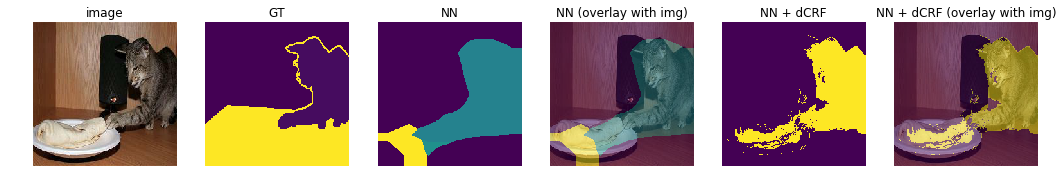

							 1092


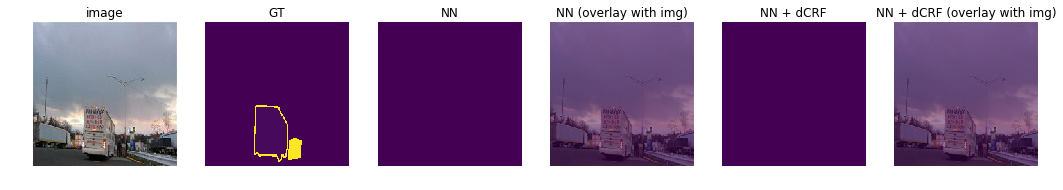

							 1242


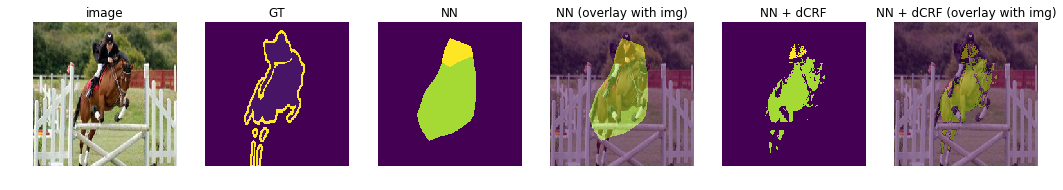

In [8]:
# indexes to visualize
indexes = np.random.randint(low=0, high=TST_SIZE, size=(30))

for index in indexes:
    if RESULTS_BUFFER:
        img, y_pred, y_true, y_pred_pp = images[index], predictions[index], groundtruth[index], predictions_pp[index]
    else:
        img = io.imread('./data/images/{}.jpg'.format(filenames[index]))
        y_true = io.imread('./data/masks/{}.png'.format(filenames[index]))
        y_pred = np.load('./data/predictions/{}.npy'.format(filenames[index]))
        y_pred_pp = io.imread('./data/predictions_pp/{}.png'.format(filenames[index]))
    if y_pred.ndim == 3:
        y_pred = np.argmax(y_pred, axis=-1)
    
    print('\t'*7, index)
    
    plt.figure(figsize=(18, 3))
    
    plt.subplot(1, 6, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('image')
    
    plt.subplot(1, 6, 2)
    plt.imshow(y_true)
    plt.axis('off')
    plt.title('GT')
    
    plt.subplot(1, 6, 3)
    plt.imshow(y_pred)
    plt.axis('off')
    plt.title('NN')
    
    plt.subplot(1, 6, 4)
    plt.imshow(img)
    plt.imshow(y_pred, alpha=0.5)
    plt.axis('off')
    plt.title('NN (overlay with img)')
    
    plt.subplot(1, 6, 5)
    plt.imshow(y_pred_pp)
    plt.title('NN + dCRF')
    plt.axis('off')
    
    plt.subplot(1, 6, 6)
    plt.imshow(img)
    plt.imshow(y_pred_pp, alpha=0.5)
    plt.title('NN + dCRF (overlay with img)')
    plt.axis('off')
    
    plt.show()

## Выводы
Сделайте выводы (в свободной форме) на основе сравнения качества по метрикам и визуально:




Не смотря на то, что метрики после постобработки уменьшились, визуально качество сегментирования в большинстве случаев увеличилось. Как видно на изображениях, исходная модель строит простые области, очень грубо приближающая правильные сегменты, а Dense-CRF затем уточняет эти области (примеры 997, 684). Правда в случаях, когда объекты не сильно выделяются на фоне, постобработка может испортить исходный результат (пример 516), но в таких случаях и исходная модель срабатывает редко. 

Итого, Dense-CRF существенно повышает визуальное "качество", особенно, если объект контрастирует со своим окружением.